In [2]:
# Imports
# ---------
import sys
import pandas as pd
import numpy as np
import feather
import os
import gc
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, MonthLocator
import matplotlib as mpl
import peakutils
from peakutils.plot import plot as pplot
import warnings
warnings.filterwarnings("ignore")

register_matplotlib_converters()

# File locations
# ----------------
pngs = './oxaria/pngs/'
data_home = './oxaria/processed/batch_2_feb21_may21/'

In [3]:
# Load stable 15-min sensor data as single df
# ------------------------------------
pm2020 = pd.read_feather(
    data_home + 'oxaria_pm_536_stable15_transients.ftr').set_index(['tag', 'rec'])
pm2021 = pd.read_feather(
    data_home + 'oxaria_pm_stable15_536_q12021_transients.ftr').set_index(['tag', 'rec'])

# Load AURN 15-min data as single df
# ------------------------------------
auto_merged = pd.read_feather(data_home+'auto_merged_ratified+2021_sept_update.ftr')

# Quite possible the baselines will have already been calculated,
# so dropping these for recalc
try:
    auto_merged.drop(
        columns=['pm10_ugg_s_bl', 'pm10_ugg_h_bl', 'pm25_ugg_s_bl'],
        axis=1,
        inplace=True)
except Exception:
    pass

In [4]:
# Load stable 15-min climate info
#---------------------------------
clim2020 = pd.read_feather(
    data_home + 'oxaria_climate_536_stable15_transients.ftr').set_index(['tag', 'rec'])
clim2021 = pd.read_feather(
    data_home + 'oxaria_climate_536_stable15_q12021_transients.ftr').set_index(['tag', 'rec'])

pm2020 = pm2020.merge(clim2020, left_index=True, right_index=True, how='inner')
pm2021 = pm2021.merge(clim2021, left_index=True, right_index=True, how='inner')


In [21]:
# Combine Q1 2021 with 2020 & remove duplicates
# -----------------------------------------------
end2020 = pd.to_datetime("2021-01-01T00:00:00", utc=True)
pm = pd.concat([pm2020.query('rec <= @end2020'), pm2021], axis=0)
pm.rename(columns={'name_x':'name'}, inplace=True)
pm.drop('name_y', axis=1, inplace=True)
pm = pm.iloc[:,:-1]

# Drop duplicates
# -----------------
pm = pm[~pm.index.duplicated(keep='last')]
pm.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 483269 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   val.mtf1       483269 non-null  float32
 1   val.pm1        483269 non-null  float32
 2   val.mtf5       483269 non-null  float32
 3   val.pm2p5      483269 non-null  float32
 4   val.mtf3       483269 non-null  float32
 5   val.pm10       483269 non-null  float32
 6   val.mtf7       483269 non-null  float32
 7   val.per        483269 non-null  float32
 8   val.sfr        483269 non-null  float32
 9   val.sht.hmd    483269 non-null  float32
 10  val.sht.tmp    483269 non-null  float32
 11  val.pm10_1     347357 non-null  float32
 12  val.pm2p5_1    347357 non-null  float32
 13  val.pm1_1      347357 non-null  float32
 14  name           483269 non-null  object 
 15

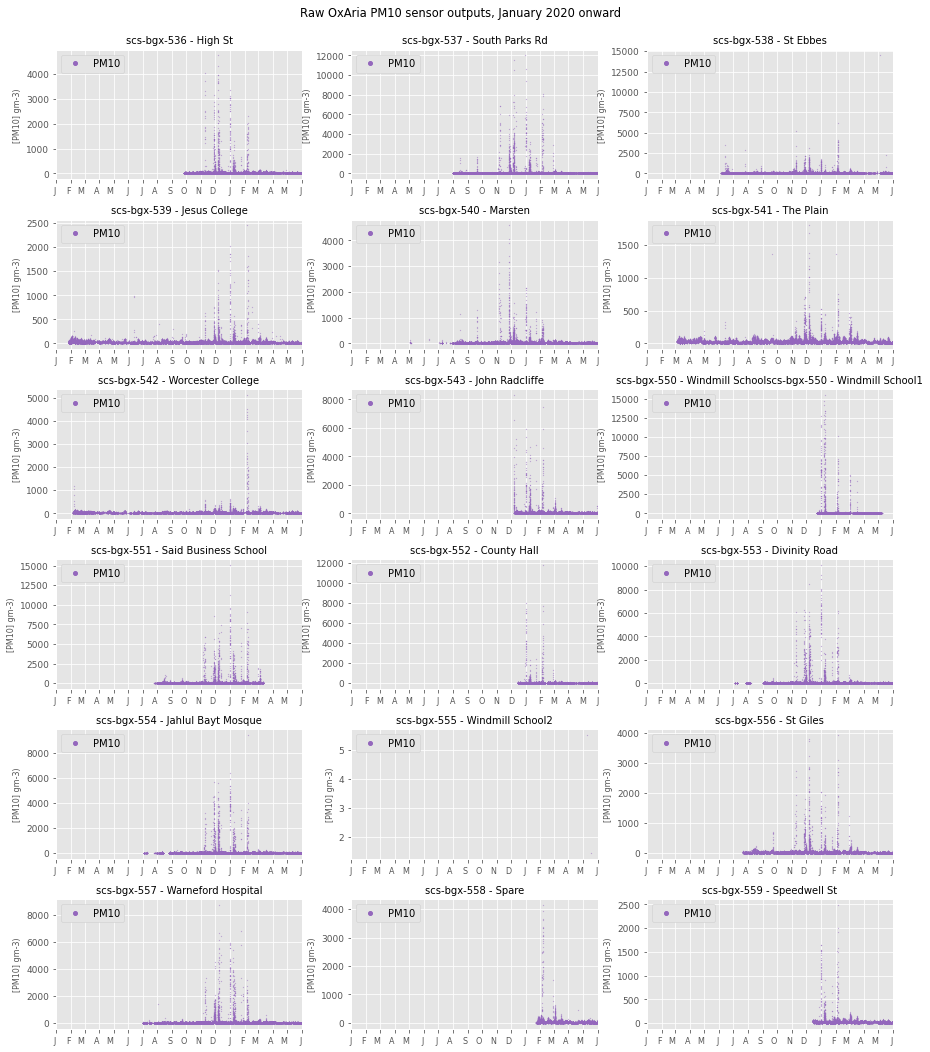

In [22]:
# PM10 plots
# -----------
plt.style.use('ggplot')
x_ticks = pd.date_range('2020-01-01', periods=18, freq='MS')
x_labels = [
    'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M',
    'A', 'M', 'J'
]

myFmt = mdates.DateFormatter('%b')
start_date=dt.datetime(2020,1,1)
end_date=dt.datetime(2021,6,1)

fig, axes = plt.subplots(nrows=6, ncols=3, sharex=False,
                         sharey=False, figsize=(15, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle('Raw OxAria PM10 sensor outputs, January 2020 onward',
             fontsize=11.5, y=0.91)

for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(level=0, inplace=True)
    t_name = dat['name'].unique()
    dat.plot(y='val.pm10_1', c='tab:purple', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='PM10', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag+' - '+t_name), fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=0,
        labelsize=8
    )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[PM10] gm-3)', fontsize=8)
    ax.set_xlabel('')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    plt.subplots_adjust(wspace=0.2, hspace=0.31)
    ax.legend(markerscale=20, frameon=True, framealpha=0.99, loc='upper left')

#plt.savefig(pngs+'oxaria0_pm25_15m_raw_sensor_ts_536_q12021.png')
plt.show()

for ax in axes_list:
    ax.remove()

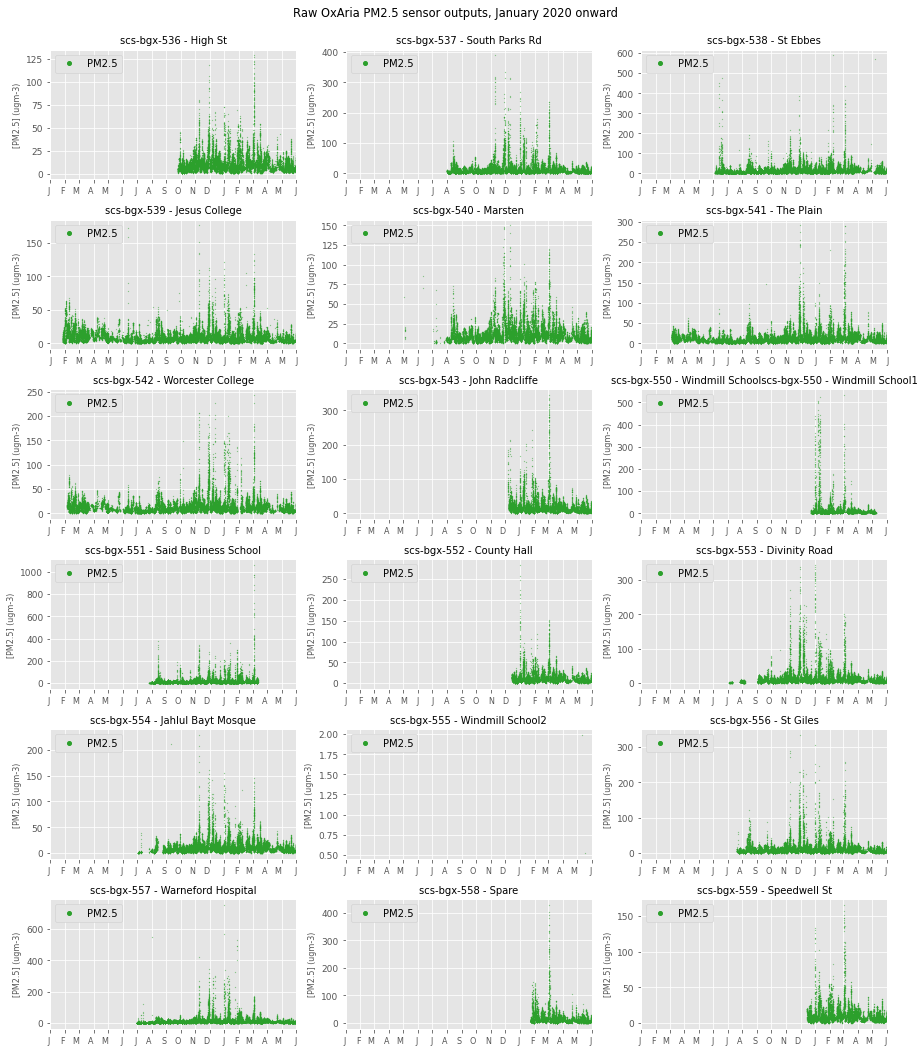

In [23]:
# PM2.5 plots
# -----------
plt.style.use('ggplot')
x_ticks = pd.date_range('2020-01-01', periods=18, freq='MS')
x_labels = [
    'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M',
    'A', 'M', 'J'
]

myFmt = mdates.DateFormatter('%b')
start_date=dt.datetime(2020,1,1)
end_date=dt.datetime(2021,6,1)

fig, axes = plt.subplots(nrows=6, ncols=3, sharex=False,
                         sharey=False, figsize=(15, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle('Raw OxAria PM2.5 sensor outputs, January 2020 onward',
             fontsize=11.5, y=0.91)

for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(level=0, inplace=True)
    t_name = dat['name'].unique()
    dat.plot(y='val.pm2p5_1', c='tab:green', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='PM2.5', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag+' - '+t_name), fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=0,
        labelsize=8
    )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[PM2.5] (ugm-3)', fontsize=8)
    ax.set_xlabel('')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    plt.subplots_adjust(wspace=0.2, hspace=0.31)
    ax.legend(markerscale=20, frameon=True, framealpha=0.99, loc='upper left')

#plt.savefig(pngs+'oxaria0_pm25_15m_raw_sensor_ts_536_q12021.png')
plt.show()

for ax in axes_list:
    ax.remove()

In [24]:
# Drop Windmill replacement, no meaningful data during this period
pm = pm.drop('scs-bgx-555', axis=0)

# Rename original Windmill which has slightly different naming in the 2020 & 2021 dataset
pm.loc['scs-bgx-550', 'name'] = 'Windmill School'
pm.loc['scs-bgx-540', 'name'] = 'New Marsten'

In [25]:
# Calc mean, std dev & coeff of variation for each sensor
# ---------------------------------------------------------
for tag, dat in pm.groupby('tag'):
    x = dat['val.pm10_1'].std()
    y = dat['val.pm10_1'].mean()
    p = x / y
    print(
        f'PM10 Mean, std. deviation & CV of {tag} is: {y:.0f},    {x:.1f},     {p:.1f}.')

# Calc mean, std dev & coeff of variation for each sensor
# ---------------------------------------------------------
print('')
for tag, dat in pm.groupby('tag'):
    x = dat['val.pm2p5_1'].std()
    y = dat['val.pm2p5_1'].mean()
    p = x / y
    print(
        f'PM2.5 Mean, std. deviation & CV of {tag} is: {y:.0f},    {x:.1f},     {p:.1f}.')

PM10 Mean, std. deviation & CV of scs-bgx-536 is: 45,    199.1,     4.4.
PM10 Mean, std. deviation & CV of scs-bgx-537 is: 75,    409.6,     5.5.
PM10 Mean, std. deviation & CV of scs-bgx-538 is: 55,    180.7,     3.3.
PM10 Mean, std. deviation & CV of scs-bgx-539 is: 26,    62.8,     2.4.
PM10 Mean, std. deviation & CV of scs-bgx-540 is: 39,    138.9,     3.6.
PM10 Mean, std. deviation & CV of scs-bgx-541 is: 29,    45.2,     1.6.
PM10 Mean, std. deviation & CV of scs-bgx-542 is: 31,    97.1,     3.2.
PM10 Mean, std. deviation & CV of scs-bgx-543 is: 69,    277.0,     4.0.
PM10 Mean, std. deviation & CV of scs-bgx-550 is: 150,    951.2,     6.3.
PM10 Mean, std. deviation & CV of scs-bgx-551 is: 107,    524.4,     4.9.
PM10 Mean, std. deviation & CV of scs-bgx-552 is: 54,    340.3,     6.3.
PM10 Mean, std. deviation & CV of scs-bgx-553 is: 80,    435.2,     5.4.
PM10 Mean, std. deviation & CV of scs-bgx-554 is: 64,    324.7,     5.1.
PM10 Mean, std. deviation & CV of scs-bgx-556 is: 37

In [26]:
pm.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 481227 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   val.mtf1       481227 non-null  float32
 1   val.pm1        481227 non-null  float32
 2   val.mtf5       481227 non-null  float32
 3   val.pm2p5      481227 non-null  float32
 4   val.mtf3       481227 non-null  float32
 5   val.pm10       481227 non-null  float32
 6   val.mtf7       481227 non-null  float32
 7   val.per        481227 non-null  float32
 8   val.sfr        481227 non-null  float32
 9   val.sht.hmd    481227 non-null  float32
 10  val.sht.tmp    481227 non-null  float32
 11  val.pm10_1     347355 non-null  float32
 12  val.pm2p5_1    347355 non-null  float32
 13  val.pm1_1      347355 non-null  float32
 14  name           481227 non-null  object 
 15

In [27]:
pm.isna().sum()

val.mtf1              0
val.pm1               0
val.mtf5              0
val.pm2p5             0
val.mtf3              0
val.pm10              0
val.mtf7              0
val.per               0
val.sfr               0
val.sht.hmd           0
val.sht.tmp           0
val.pm10_1       133872
val.pm2p5_1      133872
val.pm1_1        133872
name                  0
mag_hmd_s20           0
mag_tmp_s20           0
mean_hmd_s20          0
mean_tmp_s20          0
val.hmd               0
val.tmp               0
mag_hmd_s20c          1
mag_tmp_s20c          1
mean_hmd_s20c         1
mean_tmp_s20c         1
dtype: int64

In [28]:
# load airpls functions for St Ebbes baselining
# adaptive iteratively reweighted Penalized Least Squares algorithm function (airPLS)
# https://github.com/zmzhang/airPLS
#-------------------------------------------------------------------------------------

import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.linalg import cholesky
# from scikits.sparse.cholmod import cholesky
from scipy import sparse

from scipy.stats import norm
import matplotlib.pyplot as plt


def als(y, lam=1e6, p=0.1, itermax=10):
    r"""
    Implements an Asymmetric Least Squares Smoothing
    baseline correction algorithm (P. Eilers, H. Boelens 2005)

    Baseline Correction with Asymmetric Least Squares Smoothing
    based on https://github.com/vicngtor/BaySpecPlots

    Baseline Correction with Asymmetric Least Squares Smoothing
    Paul H. C. Eilers and Hans F.M. Boelens
    October 21, 2005

    Description from the original documentation:

    Most baseline problems in instrumental methods are characterized by a smooth
    baseline and a superimposed signal that carries the analytical information: a series
    of peaks that are either all positive or all negative. We combine a smoother
    with asymmetric weighting of deviations from the (smooth) trend get an effective
    baseline estimator. It is easy to use, fast and keeps the analytical peak signal intact.
    No prior information about peak shapes or baseline (polynomial) is needed
    by the method. The performance is illustrated by simulation and applications to
    real data.


    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        p:
            wheighting deviations. 0.5 = symmetric, <0.5: negative
            deviations are stronger suppressed
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    L = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    D = sparse.eye(L, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]
    D = D.T
    w = np.ones(L)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(L, L))
        Z = W + lam * D.dot(D.T)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z


def arpls(y, lam=1e4, ratio=0.05, itermax=100):
    r"""
    Baseline correction using asymmetrically
    reweighted penalized least squares smoothing
    Sung-June Baek, Aaron Park, Young-Jin Ahna and Jaebum Choo,
    Analyst, 2015, 140, 250 (2015)

    Abstract

    Baseline correction methods based on penalized least squares are successfully
    applied to various spectral analyses. The methods change the weights iteratively
    by estimating a baseline. If a signal is below a previously fitted baseline,
    large weight is given. On the other hand, no weight or small weight is given
    when a signal is above a fitted baseline as it could be assumed to be a part
    of the peak. As noise is distributed above the baseline as well as below the
    baseline, however, it is desirable to give the same or similar weights in
    either case. For the purpose, we propose a new weighting scheme based on the
    generalized logistic function. The proposed method estimates the noise level
    iteratively and adjusts the weights correspondingly. According to the
    experimental results with simulated spectra and measured Raman spectra, the
    proposed method outperforms the existing methods for baseline correction and
    peak height estimation.

    Inputs:
        y:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        ratio:
            wheighting deviations: 0 < ratio < 1, smaller values allow less negative values
        itermax:
            number of iterations to perform
    Output:
        the fitted background vector

    """
    N = len(y)
#  D = sparse.csc_matrix(np.diff(np.eye(N), 2))
    D = sparse.eye(N, format='csc')
    D = D[1:] - D[:-1]  # numpy.diff( ,2) does not work with sparse matrix. This is a workaround.
    D = D[1:] - D[:-1]

    H = lam * D.T * D
    w = np.ones(N)
    for i in range(itermax):
        W = sparse.diags(w, 0, shape=(N, N))
        WH = sparse.csc_matrix(W + H)
        C = sparse.csc_matrix(cholesky(WH.todense()))
        z = spsolve(C, spsolve(C.T, w * y))
        d = y - z
        dn = d[d < 0]
        m = np.mean(dn)
        s = np.std(dn)
        wt = 1. / (1 + np.exp(2 * (d - (2 * s - m)) / s))
        if np.linalg.norm(w - wt) / np.linalg.norm(w) < ratio:
            break
        w = wt
    return z


def WhittakerSmooth(x, w, lam, differences=1):
    '''
    Penalized least squares algorithm for background fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        w:
            binary masks (value of the mask is zero if a point belongs to peaks
            and one otherwise)
        lam:
            parameter that can be adjusted by user. The larger lambda is,  the
            smoother the resulting background
        differences:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    X = np.matrix(x)
    m = X.size
#    D = csc_matrix(np.diff(np.eye(m), differences))
    D = sparse.eye(m, format='csc')
    for i in range(differences):
        D = D[1:] - D[:-1]  # numpy.diff() does not work with sparse matrix. This is a workaround.
    W = sparse.diags(w, 0, shape=(m, m))
    A = sparse.csc_matrix(W + (lam * D.T * D))
    B = sparse.csc_matrix(W * X.T)
    background = spsolve(A, B)
    return np.array(background)


def airpls(x, lam=100, porder=1, itermax=100):
    '''
    airpls.py Copyright 2014 Renato Lombardo - renato.lombardo@unipa.it
    Baseline correction using adaptive iteratively reweighted penalized least squares

    This program is a translation in python of the R source code of airPLS version 2.0
    by Yizeng Liang and Zhang Zhimin - https://code.google.com/p/airpls
    Reference:
    Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive
    iteratively reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).

    Description from the original documentation:

    Baseline drift always blurs or even swamps signals and deteriorates analytical
    results, particularly in multivariate analysis.  It is necessary to correct
    baseline drift to perform further data analysis. Simple or modified polynomial
    fitting has been found to be effective in some extent. However, this method
    requires user intervention and prone to variability especially in low
    signal-to-noise ratio environments. The proposed adaptive iteratively
    reweighted Penalized Least Squares (airPLS) algorithm doesn't require any
    user intervention and prior information, such as detected peaks. It
    iteratively changes weights of sum squares errors (SSE) between the fitted
    baseline and original signals, and the weights of SSE are obtained adaptively
    using between previously fitted baseline and original signals. This baseline
    estimator is general, fast and flexible in fitting baseline.

    Adaptive iteratively reweighted penalized least squares for baseline fitting

    input
        x:
            input data (i.e. chromatogram of spectrum)
        lam:
            parameter that can be adjusted by user. The larger lambda is,
            the smoother the resulting background, z
        porder:
            integer indicating the order of the difference of penalties

    output:
        the fitted background vector
    '''
    m = x.shape[0]
    w = np.ones(m)
    for i in range(1, itermax + 1):
        z = WhittakerSmooth(x, w, lam, porder)
        d = x - z
        dssn = np.abs(d[d < 0].sum())
        if(dssn < 0.001 * (abs(x)).sum() or i == itermax):
            if(i == itermax):
                print('airpls: max iteration reached!')
            break
        w[d >= 0] = 0  # d>0 means that this point is part of a peak,
        # so its weight is set to 0 in order to ignore it
        w[d < 0] = np.exp(i * np.abs(d[d < 0]) / dssn)
        w[0] = np.exp(i * (d[d < 0]).max() / dssn)
        w[-1] = w[0]
    return z


In [29]:
# Calc St Ebbes & High St baselines using airPLS as 1st approximations - pm10
# -----------------------------------------------------------------------------

# drop rows with missing values
tmp0 = auto_merged.reset_index().dropna(
    subset=['rec', 'pm10_ugg_s', 'pm10_ugg_h'], axis=0)
# assign df cols to arrays
x0 = tmp0['rec'].values
ys = tmp0['pm10_ugg_s'].values
yh = tmp0['pm10_ugg_h'].values
# calc baseline using airpls function & default settings- st ebbes
try:
    ys_bl = airpls(ys, lam=400, porder=1, itermax=100)
except ValueError:  # raised if `y` is empty.
    pass

try:
    yh_bl = airpls(yh, lam=400, porder=1, itermax=100)
except ValueError:  # raised if `y` is empty.
    pass

# convert arrays to dfs
x0_df = pd.DataFrame(list(x0), columns=['rec'])
y_bl_df = pd.DataFrame(list(zip(ys_bl, yh_bl)),
                       columns=['pm10_ugg_s_bl', 'pm10_ugg_h_bl'])
# join cols together - rec, st ebbes baseline & high st baseline
tmp1 = pd.concat([x0_df, y_bl_df], axis=1)
# housekeeping
tmp1['rec'] = pd.to_datetime(tmp1['rec'],
                             utc=True)  # .set_index('rec',drop=True)
tmp1.set_index('rec', inplace=True, drop=True)
# join baseline info back on to source file
auto_merged = pd.merge(auto_merged,
                       tmp1,
                       how='left',
                       on='rec')

In [30]:
auto_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58464 entries, 0 to 58463
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   sitecode_s     58464 non-null  object             
 1   name_s         58464 non-null  object             
 2   rec            58464 non-null  datetime64[ns, UTC]
 3   no_ppb_s       57221 non-null  float32            
 4   no2_ppb_s      57221 non-null  float32            
 5   pm10_ugg_s     58422 non-null  float32            
 6   o3_ppb_s       35051 non-null  float32            
 7   pm25_ugg_s     58422 non-null  float32            
 8   fidas_t_s      58437 non-null  float32            
 9   fidas_rh_s     58437 non-null  float32            
 10  sitecode_h     58464 non-null  object             
 11  name_h         58464 non-null  object             
 12  no_ppb_h       56975 non-null  float32            
 13  no2_ppb_h      56975 non-null  float32        

In [31]:
# Calc St Ebbes baselines using airPLS as 1st approximations - pm2.5
# --------------------------------------------------------------------

# drop rows with missing values
tmp0 = auto_merged.reset_index().dropna(subset=['rec', 'pm25_ugg_s'], axis=0)
# assign df cols to arrays
x0 = tmp0['rec'].values
ys = tmp0['pm25_ugg_s'].values
# calc baseline using airpls function & default settings- st ebbes
try:
    ys_bl = airpls(ys, lam=400, porder=1, itermax=100)
except ValueError:  # raised if `y` is empty.
    pass

# convert arrays to dfs
x0_df = pd.DataFrame(list(x0), columns=['rec'])
y_bl_df = pd.DataFrame(ys_bl, columns=['pm25_ugg_s_bl'])
# join cols together - rec, st ebbes baseline & high st baseline
tmp1 = pd.concat([x0_df, y_bl_df], axis=1)
# housekeeping
tmp1['rec'] = pd.to_datetime(tmp1['rec'],
                             utc=True)  # .set_index('rec',drop=True)
tmp1.set_index('rec', inplace=True, drop=True)
# join baseline info back on to source file
auto_merged = pd.merge(auto_merged,
                       tmp1,
                       how='left',
                       on='rec')
# housekeeping
auto_merged.reset_index().set_index('rec', inplace=True, drop=True)
auto_merged[['pm25_ugg_s_bl']] = auto_merged[['pm25_ugg_s_bl'
                                              ]].astype(np.float32)

In [32]:
auto_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58464 entries, 0 to 58463
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   sitecode_s     58464 non-null  object             
 1   name_s         58464 non-null  object             
 2   rec            58464 non-null  datetime64[ns, UTC]
 3   no_ppb_s       57221 non-null  float32            
 4   no2_ppb_s      57221 non-null  float32            
 5   pm10_ugg_s     58422 non-null  float32            
 6   o3_ppb_s       35051 non-null  float32            
 7   pm25_ugg_s     58422 non-null  float32            
 8   fidas_t_s      58437 non-null  float32            
 9   fidas_rh_s     58437 non-null  float32            
 10  sitecode_h     58464 non-null  object             
 11  name_h         58464 non-null  object             
 12  no_ppb_h       56975 non-null  float32            
 13  no2_ppb_h      56975 non-null  float32        

In [33]:
pm.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 481227 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   val.mtf1       481227 non-null  float32
 1   val.pm1        481227 non-null  float32
 2   val.mtf5       481227 non-null  float32
 3   val.pm2p5      481227 non-null  float32
 4   val.mtf3       481227 non-null  float32
 5   val.pm10       481227 non-null  float32
 6   val.mtf7       481227 non-null  float32
 7   val.per        481227 non-null  float32
 8   val.sfr        481227 non-null  float32
 9   val.sht.hmd    481227 non-null  float32
 10  val.sht.tmp    481227 non-null  float32
 11  val.pm10_1     347355 non-null  float32
 12  val.pm2p5_1    347355 non-null  float32
 13  val.pm1_1      347355 non-null  float32
 14  name           481227 non-null  object 
 15

In [34]:
# Calc pm10 & pm2.5 sensor baseline with airPLS
# -----------------------------------------------

# pm10
# ------
# create temporary list
tmp_list = []
# calc baselines for each sensor group
for tag, df in pm.reset_index().groupby('tag'):
    # drop rows with missing data
    tmp0 = df.dropna(subset=['rec', 'val.pm10_1'], axis=0)
    # assign df cols to arrays
    tag0 = tmp0['tag'].values
    x0 = tmp0['rec'].values
    y0 = tmp0['val.pm10_1'].values
    # calc baseline using airpls function & default settings
    y0_bl = airpls(y0, lam=400, porder=1, itermax=100)
    # convert arrays to dfs
    x0_df = pd.DataFrame(list(zip(tag0, x0)), columns=['tag', 'rec'])
    y0_bl_df = pd.DataFrame(list(y0_bl), columns=['val.pm10_1_bl'])
    # join cols together - tag, rec & no2 baseline
    tmp1 = pd.concat([x0_df, y0_bl_df], axis=1)
    # housekeeping
    tmp1['rec'] = pd.to_datetime(tmp1['rec'], utc=True)
    # append to rmp_list for each iteration
    tmp_list.append(tmp1)
# combine the list of dfs into single df
tmp_df = pd.concat(tmp_list).set_index(['tag', 'rec'], drop=True)
# merge info back on to source df
pm = pd.merge(pm, tmp_df, how='left', on=['tag', 'rec'])
pm.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 481227 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   val.mtf1       481227 non-null  float32
 1   val.pm1        481227 non-null  float32
 2   val.mtf5       481227 non-null  float32
 3   val.pm2p5      481227 non-null  float32
 4   val.mtf3       481227 non-null  float32
 5   val.pm10       481227 non-null  float32
 6   val.mtf7       481227 non-null  float32
 7   val.per        481227 non-null  float32
 8   val.sfr        481227 non-null  float32
 9   val.sht.hmd    481227 non-null  float32
 10  val.sht.tmp    481227 non-null  float32
 11  val.pm10_1     347355 non-null  float32
 12  val.pm2p5_1    347355 non-null  float32
 13  val.pm1_1      347355 non-null  float32
 14  name           481227 non-null  object 
 15

In [35]:
# pm2.5
# -------
# create temporary list
tmp_list = []
# calc baselines for each sensor group
for tag, df in pm.reset_index().groupby('tag'):
    # drop rows with missing data
    tmp0 = df.dropna(subset=['rec', 'val.pm2p5_1'], axis=0)
    # assign df cols to arrays
    tag0 = tmp0['tag'].values
    x0 = tmp0['rec'].values
    y0 = tmp0['val.pm2p5_1'].values
    # calc baseline using airpls function & default settings
    y0_bl = airpls(y0, lam=400, porder=1, itermax=100)
    # convert arrays to dfs
    x0_df = pd.DataFrame(list(zip(tag0, x0)), columns=['tag', 'rec'])
    y0_bl_df = pd.DataFrame(list(y0_bl), columns=['val.pm2p5_1_bl'])
    # join cols together - tag, rec & no2 baseline
    tmp1 = pd.concat([x0_df, y0_bl_df], axis=1)
    # housekeeping
    tmp1['rec'] = pd.to_datetime(tmp1['rec'], utc=True)
    # append to rmp_list for each iteration
    tmp_list.append(tmp1)
# combine the list of dfs into single df
tmp_df = pd.concat(tmp_list).set_index(['tag', 'rec'], drop=True)
# merge info back on to source df
pm = pd.merge(pm, tmp_df, how='left', on=['tag', 'rec'])
pm.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 481227 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   val.mtf1        481227 non-null  float32
 1   val.pm1         481227 non-null  float32
 2   val.mtf5        481227 non-null  float32
 3   val.pm2p5       481227 non-null  float32
 4   val.mtf3        481227 non-null  float32
 5   val.pm10        481227 non-null  float32
 6   val.mtf7        481227 non-null  float32
 7   val.per         481227 non-null  float32
 8   val.sfr         481227 non-null  float32
 9   val.sht.hmd     481227 non-null  float32
 10  val.sht.tmp     481227 non-null  float32
 11  val.pm10_1      347355 non-null  float32
 12  val.pm2p5_1     347355 non-null  float32
 13  val.pm1_1       347355 non-null  float32
 14  name            481227 non-

<Figure size 432x288 with 0 Axes>

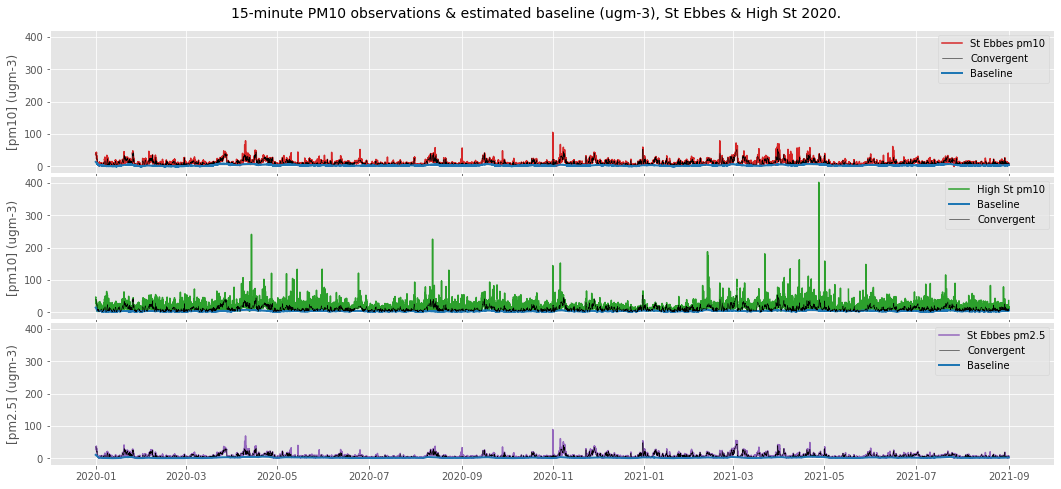

Average St Ebbes baseline = 3.493659215007527
Min St Ebbes baseline = 0.8798434986614436
Average High St baseline = 4.339451805421874
Min High St baseline = 3.2657727088037234


In [36]:
# Plot St Ebbes timeseries baseline PM10
# ---------------------------------------
auto_merged.set_index('rec',inplace=True)

plt.tight_layout()
plt.style.use('ggplot')
fig, (ax1, ax2, ax3) = plt.subplots(3,
                                    figsize=(18, 8),
                                    sharex=False,
                                    sharey=True)
plt.suptitle(
    '15-minute PM10 observations & estimated baseline (ugm-3), St Ebbes & High St 2020.',
    y=0.92,
    fontsize=14)
ax1.plot(auto_merged['pm10_ugg_s'], label='St Ebbes pm10', c='tab:red')
tmp = auto_merged.query('abs_pm10_diff <= 2.0')
ax1.plot(tmp['pm10_ugg_s'], lw=0.5, c='k', label='Convergent')
ax1.plot(auto_merged['pm10_ugg_s_bl'], lw=2, label='Baseline', c='tab:blue')
ax2.plot(auto_merged['pm10_ugg_h'], c='tab:green', label='High St pm10')
ax2.plot(auto_merged['pm10_ugg_h_bl'], lw=2, label='Baseline', c='tab:blue')
ax2.plot(tmp.index, tmp['pm10_ugg_s'], lw=0.5, c='k', label='Convergent')
ax3.plot(auto_merged['pm25_ugg_s'], label='St Ebbes pm2.5', c='tab:purple')
tmp = auto_merged.query('abs_pm10_diff <= 2.0')
ax3.plot(tmp.index, tmp['pm25_ugg_s'], lw=0.5, c='k', label='Convergent')
ax3.plot(auto_merged['pm25_ugg_s_bl'], lw=2, label='Baseline', c='tab:blue')
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_ylabel('[pm10] (ugm-3)')
ax2.set_ylabel('[pm10] (ugm-3)')
ax3.set_ylabel('[pm2.5] (ugm-3)')

plt.subplots_adjust(hspace=0.02)
plt.show()

print('Average St Ebbes baseline = ' + str(auto_merged['pm10_ugg_s_bl'].mean()))
print('Min St Ebbes baseline = ' + str(auto_merged['pm10_ugg_s_bl'].min()))
print('Average High St baseline = ' + str(auto_merged['pm10_ugg_h_bl'].mean()))
print('Min High St baseline = ' + str(auto_merged['pm10_ugg_h_bl'].min()))

<Figure size 432x288 with 0 Axes>

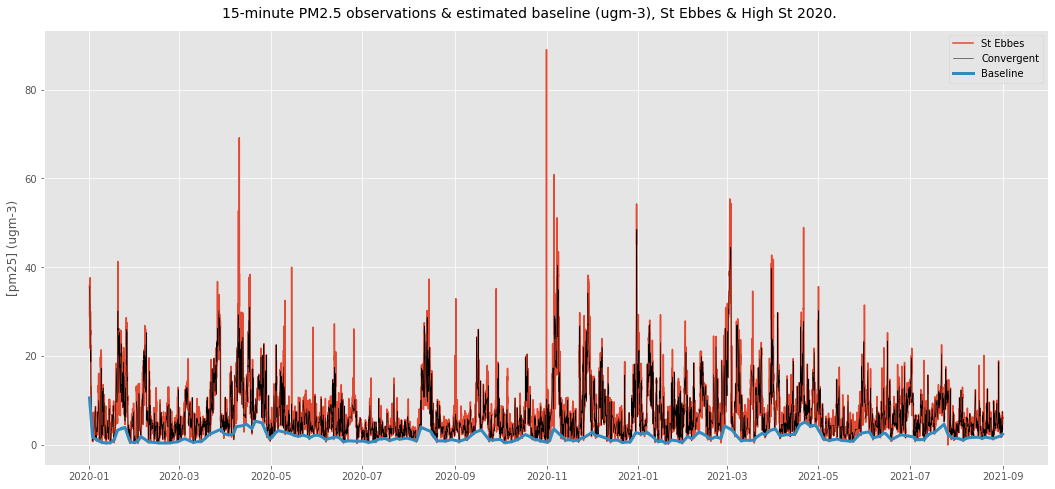

Average St Ebbes baseline = 1.8880618
Min St Ebbes baseline = 0.43561602


In [37]:
# Plot St Ebbes timeseries baseline PM2.5
#----------------------------------------
plt.tight_layout()
plt.style.use('ggplot')
fig, ax1 = plt.subplots(1, figsize=(18, 8), sharex=True, sharey=True)
plt.suptitle(
    '15-minute PM2.5 observations & estimated baseline (ugm-3), St Ebbes & High St 2020.',
    y=0.92,
    fontsize=14)
ax1.plot(auto_merged['pm25_ugg_s'], label='St Ebbes')
tmp = auto_merged.query('abs_pm10_diff <= 2.0')
ax1.plot(tmp['pm25_ugg_s'], lw=0.5, c='k', label='Convergent')
ax1.plot(auto_merged['pm25_ugg_s_bl'],
         lw=3,
         label='Baseline')
ax1.legend()
ax1.set_ylabel('[pm25] (ugm-3)')

plt.subplots_adjust(hspace=0.02)
plt.show()

print('Average St Ebbes baseline = ' + str(auto_merged['pm25_ugg_s_bl'].mean()))
print('Min St Ebbes baseline = ' + str(auto_merged['pm25_ugg_s_bl'].min()))

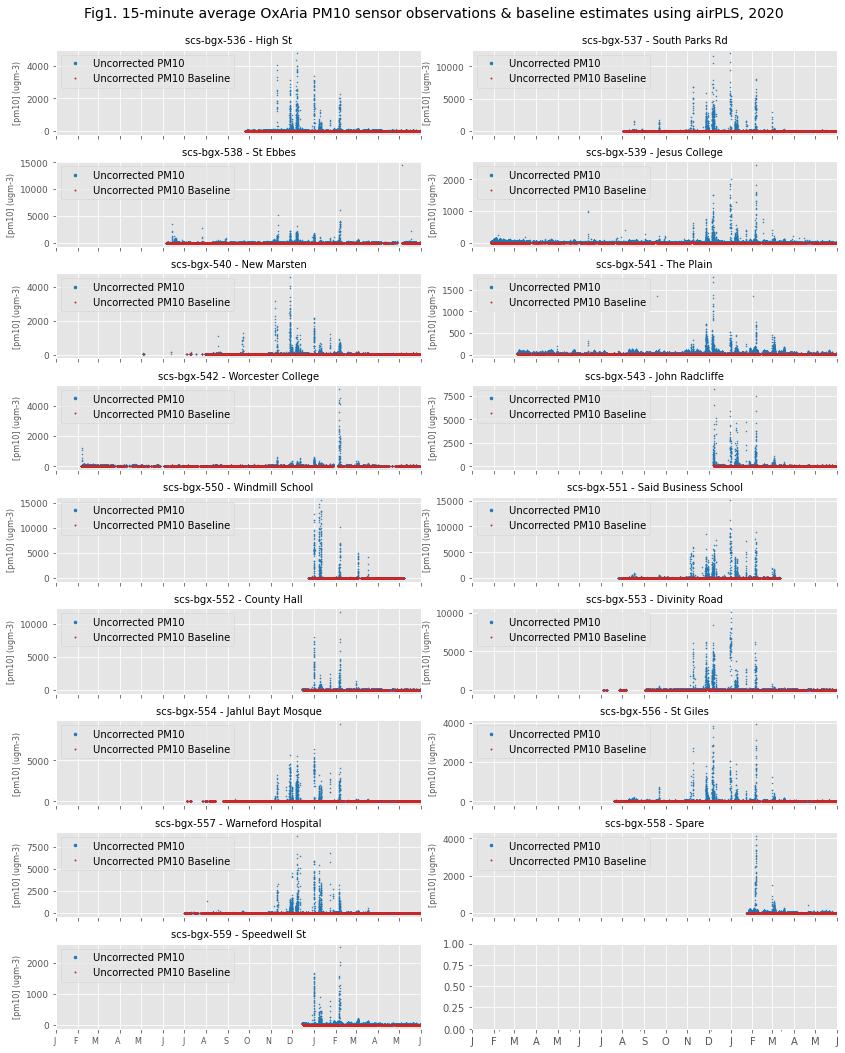

In [38]:
# Plot 15-minute sensor pm10 & its baseline
# -----------------------------------------

plt.style.use('ggplot')
x_ticks = pd.date_range('2020-01-01', periods=18, freq='MS')
x_labels = [
    'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M',
    'A', 'M', 'J'
]

myFmt = mdates.DateFormatter('%b')
start_date=dt.datetime(2020,1,1)
end_date=dt.datetime(2021,6,1)

fig, axes = plt.subplots(nrows=9, ncols=2, sharex=True,
                         sharey=False, figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fig1. 15-minute average OxAria PM10 sensor observations & baseline estimates using airPLS, 2020',
    fontsize=14,
    y=0.91)

for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat = dat.reset_index()
    t_name = dat['name'].unique()
    dat = dat[['tag','rec','val.pm10_1','val.pm10_1_bl']].sort_values(['tag','rec']).dropna(subset=['val.pm10_1'])
    dat.plot(x='rec', y='val.pm10_1', c='tab:blue', linewidth=0.5, marker='o', ms=0.5, ls='',
             label='Uncorrected PM10', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec', y='val.pm10_1_bl', c='tab:red', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='Uncorrected PM10 Baseline', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag+' - '+t_name), fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=0,
        labelsize=8
    )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[pm10] (ugm-3)', fontsize=8)
    ax.set_xlabel('')
    plt.subplots_adjust(wspace=0.14, hspace=0.31)
    ax.legend(markerscale=5, frameon=True, framealpha=0.75, loc='upper left')

#plt.savefig(pngs+'oxaria0_pm10_15m_raw_sensor_bl_ts_ratified+2021.png')
plt.show()

for ax in axes_list:
    ax.remove()

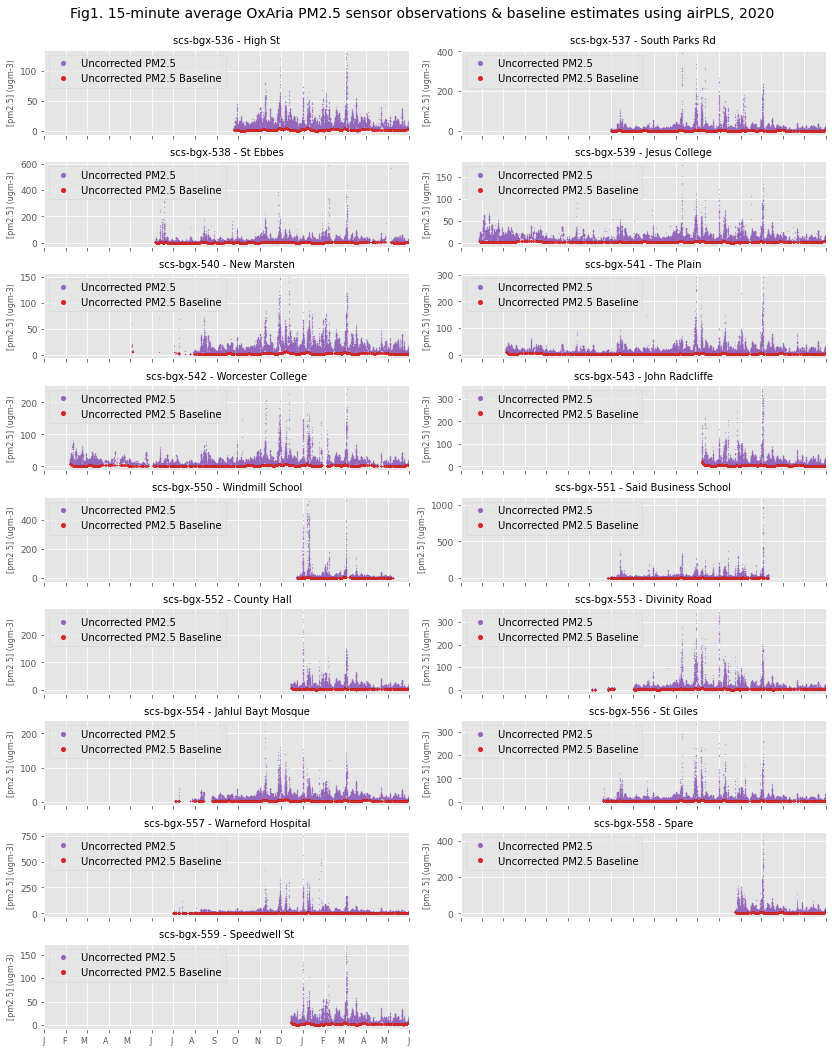

In [39]:
# Plot 15-minute snsor pm2.5 & its baseline
# -----------------------------------------

plt.style.use('ggplot')
x_ticks = pd.date_range('2020-01-01', periods=18, freq='MS')
x_labels = [
    'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M',
    'A', 'M', 'J'
]

myFmt = mdates.DateFormatter('%b')
start_date=dt.datetime(2020,1,1)
end_date=dt.datetime(2021,6,1)
fig, axes = plt.subplots(nrows=9, ncols=2, sharex=True,
                         sharey=False, figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fig1. 15-minute average OxAria PM2.5 sensor observations & baseline estimates using airPLS, 2020',
    fontsize=14,
    y=0.91)

for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()
    dat = dat[['tag','rec','val.pm2p5_1','val.pm2p5_1_bl']].sort_values(['tag','rec']).dropna(subset=['val.pm2p5_1'])
    dat.plot(x='rec', y='val.pm2p5_1', c='tab:purple', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='Uncorrected PM2.5', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec', y='val.pm2p5_1_bl', c='tab:red', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='Uncorrected PM2.5 Baseline', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag+' - '+t_name), fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=0,
        labelsize=8
    )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[pm2.5] (ugm-3)', fontsize=8)
    ax.set_xlabel('')
    plt.subplots_adjust(wspace=0.14, hspace=0.31)
    ax.legend(markerscale=20, frameon=True, framealpha=0.75, loc='upper left')
fig.delaxes(axes_list.pop(-1))

#plt.savefig(pngs+'oxaria0_pm10_15m_raw_sensor_bl_ts_ratified+2021.png')
plt.show()

for ax in axes_list:
    ax.remove()

In [40]:
# Adjust sensor PM output for baseline
#---------------------------------------
pm['val.pm10_1_c0'] = pm['val.pm10_1'] - pm['val.pm10_1_bl'] 
pm['val.pm2p5_1_c0'] = pm['val.pm2p5_1'] - pm['val.pm2p5_1_bl'] 


In [41]:
pm.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 481227 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   val.mtf1        481227 non-null  float32
 1   val.pm1         481227 non-null  float32
 2   val.mtf5        481227 non-null  float32
 3   val.pm2p5       481227 non-null  float32
 4   val.mtf3        481227 non-null  float32
 5   val.pm10        481227 non-null  float32
 6   val.mtf7        481227 non-null  float32
 7   val.per         481227 non-null  float32
 8   val.sfr         481227 non-null  float32
 9   val.sht.hmd     481227 non-null  float32
 10  val.sht.tmp     481227 non-null  float32
 11  val.pm10_1      347355 non-null  float32
 12  val.pm2p5_1     347355 non-null  float32
 13  val.pm1_1       347355 non-null  float32
 14  name            481227 non-

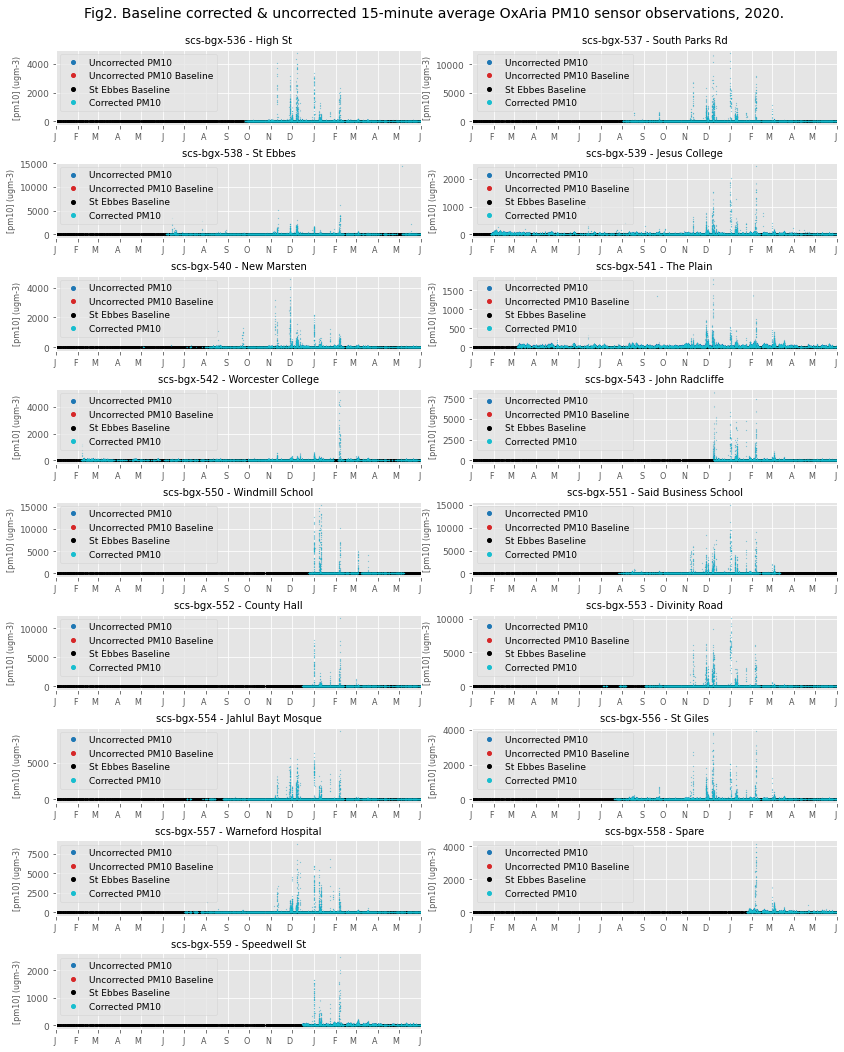

In [42]:
# Plot 15-minute sensor pm10, baseline & baseline corrected sensor outputs
#-------------------------------------------------------------------------
auto_merged.reset_index(inplace=True)

plt.style.use('ggplot')
x_ticks = pd.date_range('2020-01-01', periods=18, freq='MS')
x_labels = [
    'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M',
    'A', 'M', 'J'
]

myFmt = mdates.DateFormatter('%b')
start_date=dt.datetime(2020,1,1)
end_date=dt.datetime(2021,6,1)

fig, axes = plt.subplots(nrows=9,
                         ncols=2,
                         sharex=False,
                         sharey=False,
                         figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fig2. Baseline corrected & uncorrected 15-minute average OxAria PM10 sensor observations, 2020.',
    fontsize=14,
    y=0.91)

for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()[0]
    dat = dat[['tag','rec','val.pm10_1','val.pm10_1_bl','val.pm10_1_c0']].sort_values(['tag','rec']).dropna(subset=['val.pm10_1'])
    dat.plot(x='rec',y='val.pm10_1', c='tab:blue',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Uncorrected PM10', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm10_1_bl', c='tab:red',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Uncorrected PM10 Baseline', ax=ax, legend=True, zorder=1)
    auto_merged.plot(x='rec',y='pm10_ugg_s_bl', c='k',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='St Ebbes Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm10_1_c0', c='tab:cyan',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Corrected PM10', ax=ax, legend=True, zorder=1)

    ax.set_title(''.join(str(tag) + ' - ' + str(t_name)), fontsize=10)
    ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[pm10] (ugm-3)', fontsize=8)
    ax.set_xlabel('')

    plt.subplots_adjust(wspace=0.14, hspace=0.5)
    ax.legend(markerscale=40, frameon=True, framealpha=0.75, loc='upper left', fontsize=9)
fig.delaxes(axes_list.pop(-1))

#plt.savefig(pngs+'oxaria0_pm10_15m_raw_sensor_ts_ratified+2021.png')
plt.show()

for ax in axes_list:
    ax.remove()

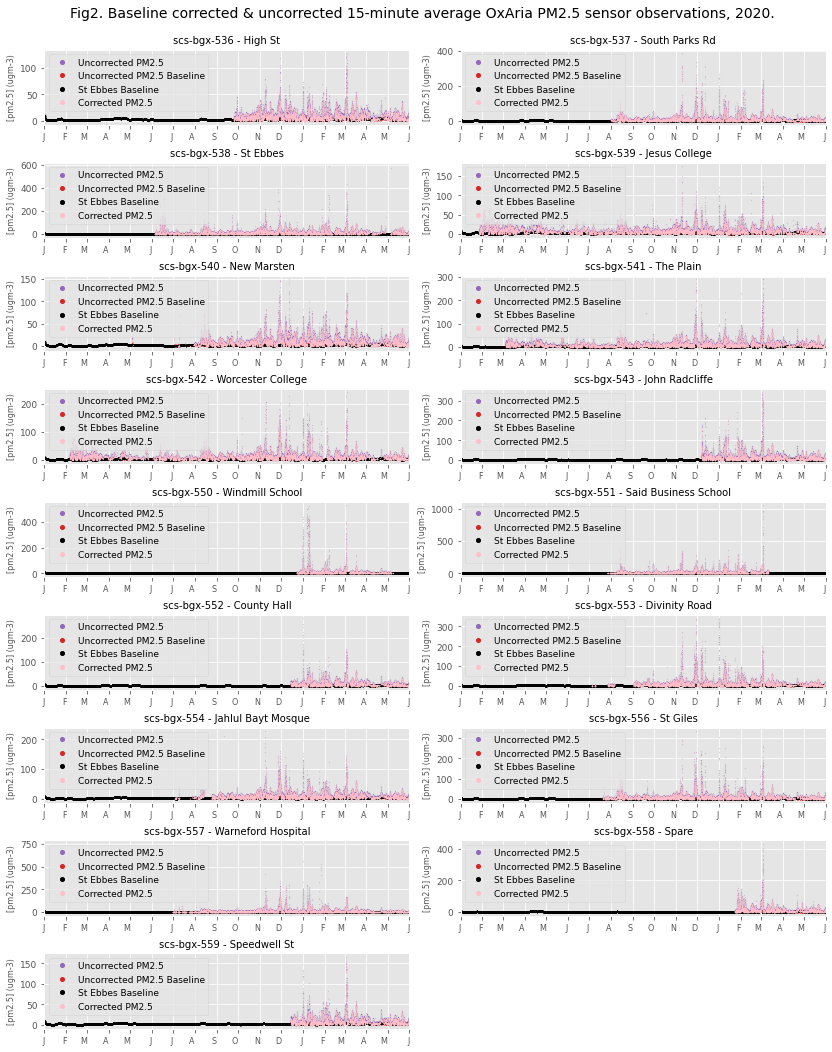

In [43]:
# Plot 15-minute sensor pm2.5, baseline & baseline corrected sensor outputs
#-------------------------------------------------------------------------

plt.style.use('ggplot')
x_ticks = pd.date_range('2020-01-01', periods=18, freq='MS')
x_labels = [
    'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M',
    'A', 'M', 'J'
]

myFmt = mdates.DateFormatter('%b')
start_date=dt.datetime(2020,1,1)
end_date=dt.datetime(2021,6,1)

fig, axes = plt.subplots(nrows=9,
                         ncols=2,
                         sharex=False,
                         sharey=False,
                         figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fig2. Baseline corrected & uncorrected 15-minute average OxAria PM2.5 sensor observations, 2020.',
    fontsize=14,
    y=0.91)

for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()[0]
    dat = dat[['tag','rec','val.pm2p5_1','val.pm2p5_1_bl','val.pm2p5_1_c0']].sort_values(['tag','rec']).dropna(subset=['val.pm2p5_1'])
    dat.plot(x='rec',y='val.pm2p5_1', c='tab:purple',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Uncorrected PM2.5', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm2p5_1_bl', c='tab:red',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Uncorrected PM2.5 Baseline', ax=ax, legend=True, zorder=1)
    auto_merged.plot(x='rec',y='pm25_ugg_s_bl', c='k',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='St Ebbes Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec',y='val.pm2p5_1_c0', c='pink',linewidth=0.5, marker='o', ms=0.1, ls='', \
             label='Corrected PM2.5', ax=ax, legend=True, zorder=1)

    ax.set_title(''.join(tag + ' - ' + t_name), fontsize=10)
    ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[pm2.5] (ugm-3)', fontsize=8)
    ax.set_xlabel('')
    plt.subplots_adjust(wspace=0.14, hspace=0.5)
    ax.legend(markerscale=40, frameon=True, framealpha=0.75, loc='upper left', fontsize=9)
fig.delaxes(axes_list.pop(-1))

#plt.savefig(pngs+'oxaria0_pm25_15m_raw_sensor_ts_ratified+2021.png')
plt.show()

for ax in axes_list:
    ax.remove()

In [44]:
pm.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 481227 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   val.mtf1        481227 non-null  float32
 1   val.pm1         481227 non-null  float32
 2   val.mtf5        481227 non-null  float32
 3   val.pm2p5       481227 non-null  float32
 4   val.mtf3        481227 non-null  float32
 5   val.pm10        481227 non-null  float32
 6   val.mtf7        481227 non-null  float32
 7   val.per         481227 non-null  float32
 8   val.sfr         481227 non-null  float32
 9   val.sht.hmd     481227 non-null  float32
 10  val.sht.tmp     481227 non-null  float32
 11  val.pm10_1      347355 non-null  float32
 12  val.pm2p5_1     347355 non-null  float32
 13  val.pm1_1       347355 non-null  float32
 14  name            481227 non-

In [45]:
# Calc baseline of the corrected pm10 sensor trace
#-------------------------------------------------
tmp_list = []

for tag, df in pm.reset_index().groupby('tag'):
    tmp0 = df.dropna(subset=['rec', 'val.pm10_1_c0'], axis=0)
    tag0 = tmp0['tag'].values
    x0 = tmp0['rec'].values
    y0 = tmp0['val.pm10_1_c0'].values
    y0_bl = airpls(
        y0, lam=400, porder=1, itermax=100
    )  # these default values seem to deliver good results, stay with
    x0_df = pd.DataFrame(list(zip(tag0,x0)), columns=['tag','rec'])
    y0_bl_df = pd.DataFrame(list(y0_bl), columns=['val.pm10_1_c0_bl'])
    tmp1 = pd.concat([x0_df, y0_bl_df], axis=1)
    tmp1['rec'] = pd.to_datetime(tmp1['rec'],
                                 utc=True)  # .set_index('rec',drop=True)
    tmp_list.append(tmp1)
tmp_df = pd.concat(tmp_list).set_index(['tag','rec'], drop=True)

pm = pd.merge(pm, tmp_df, how='left', left_index=True, right_index=True)
pm = pm.reset_index().merge(auto_merged.loc[:,['rec','pm10_ugg_s_bl']], how='left', on='rec')
pm['pm10bl_1_c0_offset'] = pm['pm10_ugg_s_bl'] - pm['val.pm10_1_c0_bl']
pm['val.pm10_1_c1'] = pm['val.pm10_1_c0'] + pm['pm10bl_1_c0_offset']
pm = pm.set_index(['tag','rec'])


In [46]:
# Calc baseline of the corrected pm2.5 sensor trace
#-------------------------------------------------
tmp_list = []

for tag, df in pm.reset_index().groupby('tag'):
    tmp0 = df.dropna(subset=['rec', 'val.pm2p5_1_c0'], axis=0)
    tag0 = tmp0['tag'].values
    x0 = tmp0['rec'].values
    y0 = tmp0['val.pm2p5_1_c0'].values
    y0_bl = airpls(
        y0, lam=400, porder=1, itermax=100
    )  # these default values seem to deliver good results, stay with
    x0_df = pd.DataFrame(list(zip(tag0,x0)), columns=['tag','rec'])
    y0_bl_df = pd.DataFrame(list(y0_bl), columns=['val.pm2p5_1_c0_bl'])
    tmp1 = pd.concat([x0_df, y0_bl_df], axis=1)
    tmp1['rec'] = pd.to_datetime(tmp1['rec'],
                                 utc=True)  # .set_index('rec',drop=True)
    tmp_list.append(tmp1)
       
tmp_df = pd.concat(tmp_list).set_index(['tag','rec'], drop=True) 
pm = pd.merge(pm, tmp_df, how='left', left_index=True, right_index=True)
pm = pm.reset_index().merge(auto_merged.loc[:,['rec','pm25_ugg_s_bl']], how='left', on='rec')
pm['pm25bl_1_c0_offset'] = pm['pm25_ugg_s_bl'] - pm['val.pm2p5_1_c0_bl']
pm['val.pm2p5_1_c1'] = pm['val.pm2p5_1_c0'] + pm['pm25bl_1_c0_offset']
pm = pm.set_index(['tag','rec'])


In [47]:
pm.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 481227 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 37 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   val.mtf1            481227 non-null  float32
 1   val.pm1             481227 non-null  float32
 2   val.mtf5            481227 non-null  float32
 3   val.pm2p5           481227 non-null  float32
 4   val.mtf3            481227 non-null  float32
 5   val.pm10            481227 non-null  float32
 6   val.mtf7            481227 non-null  float32
 7   val.per             481227 non-null  float32
 8   val.sfr             481227 non-null  float32
 9   val.sht.hmd         481227 non-null  float32
 10  val.sht.tmp         481227 non-null  float32
 11  val.pm10_1          347355 non-null  float32
 12  val.pm2p5_1         347355 non-null  float32
 13  val.pm1_1    

In [48]:
pm.loc[:,['pm10bl_1_c0_offset','pm25bl_1_c0_offset']].describe()

,pm10bl_1_c0_offset,pm25bl_1_c0_offset
count,327260.000000,347125.000000
mean,2.900459,1.569321
std,1.646500,0.846290
min,-88.984655,-6.418198
25%,1.942249,0.948757
50%,2.538334,1.315978
75%,3.820677,2.083811
max,9.543694,5.328775


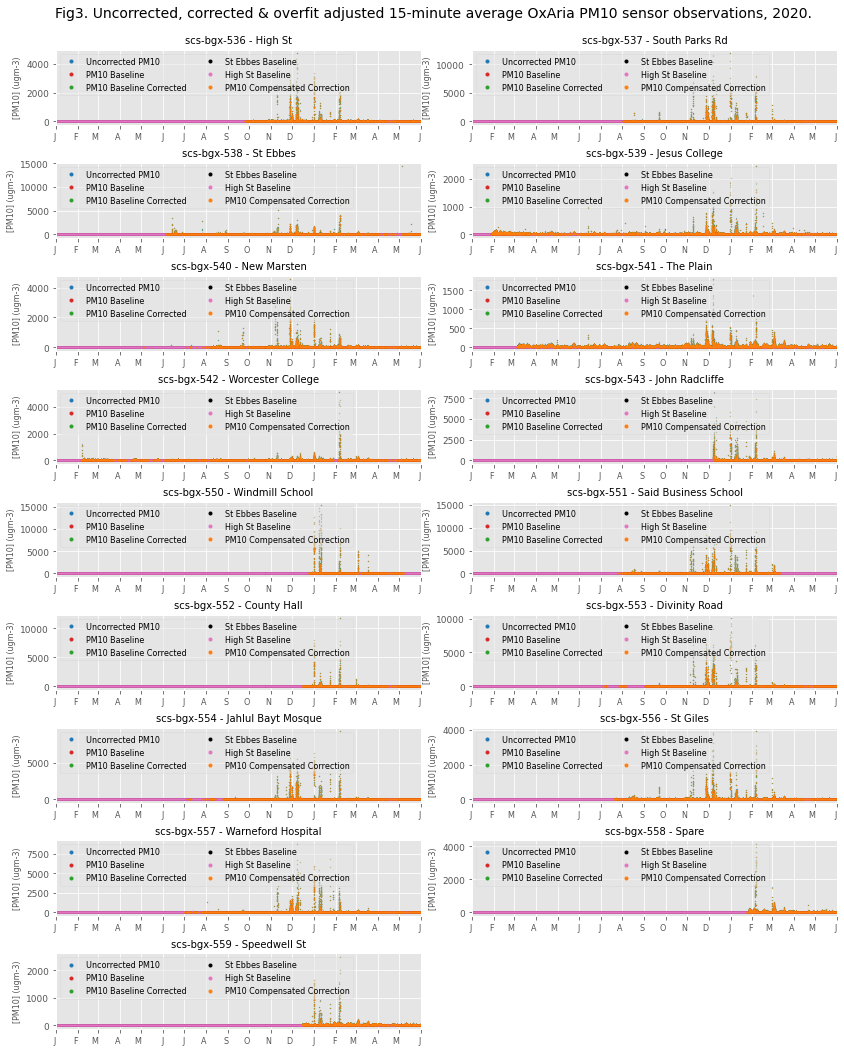

In [49]:
# Plot 15-minute sensor pm10, baseline & baseline corrected sensor outputs
# -------------------------------------------------------------------------

plt.style.use('ggplot')
x_ticks = pd.date_range('2020-01-01', periods=18, freq='MS')
x_labels = [
    'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M',
    'A', 'M', 'J'
]

myFmt = mdates.DateFormatter('%b')
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2021, 6, 1)

fig, axes = plt.subplots(nrows=9,
                         ncols=2,
                         sharex=False,
                         sharey=False,
                         figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fig3. Uncorrected, corrected & overfit adjusted 15-minute average OxAria PM10 sensor observations, 2020.',
    fontsize=14,
    y=0.91)
for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()[0]
    dat = dat[['tag', 'rec', 'val.pm10_1', 'val.pm10_1_bl', 'val.pm10_1_c0',
               'val.pm10_1_c1']].sort_values(['tag', 'rec']).dropna(subset=['val.pm10_1'])
    dat.plot(x='rec', y='val.pm10_1', c='tab:blue', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='Uncorrected PM10', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec', y='val.pm10_1_bl', c='tab:red', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='PM10 Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec', y='val.pm10_1_c0', c='tab:green', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='PM10 Baseline Corrected', ax=ax, legend=True, zorder=1)
    auto_merged.plot(x='rec', y='pm10_ugg_s_bl', c='k', linewidth=0.5, marker='o', ms=0.2, ls='',
                     label='St Ebbes Baseline', ax=ax, legend=True, zorder=1)
    auto_merged.plot(x='rec', y='pm10_ugg_h_bl', c='tab:pink', linewidth=0.5, marker='o', ms=0.2, ls='',
                     label='High St Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec', y='val.pm10_1_c1', c='tab:orange', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='PM10 Compensated Correction', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag + ' - ' + t_name), fontsize=10)
    ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[PM10] (ugm-3)', fontsize=8)
    ax.set_xlabel('')
    plt.subplots_adjust(wspace=0.14, hspace=0.5)
    ax.legend(markerscale=15, frameon=True, framealpha=0.5,
              loc='upper left', ncol=2, fontsize=8)
fig.delaxes(axes_list.pop(-1))

#plt.savefig(pngs+'oxaria0_pm10_15m_raw_sensor_bl_corrected_ts_ratified+2021.png')
plt.show()

for ax in axes_list:
    ax.remove()

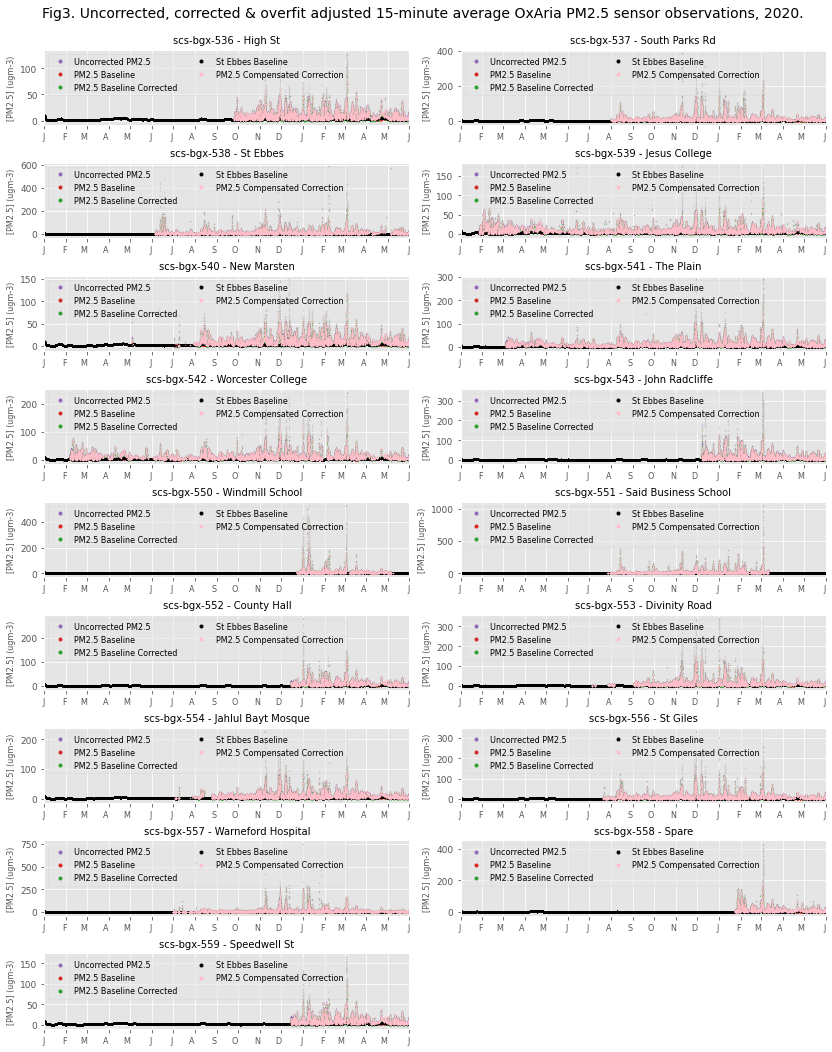

In [50]:
# Plot 15-minute sensor pm2.5, baseline & baseline corrected sensor outputs
# -------------------------------------------------------------------------

plt.style.use('ggplot')
x_ticks = pd.date_range('2020-01-01', periods=18, freq='MS')
x_labels = [
    'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M',
    'A', 'M', 'J'
]

myFmt = mdates.DateFormatter('%b')
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2021, 6, 1)

fig, axes = plt.subplots(nrows=9,
                         ncols=2,
                         sharex=False,
                         sharey=False,
                         figsize=(14, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle(
    'Fig3. Uncorrected, corrected & overfit adjusted 15-minute average OxAria PM2.5 sensor observations, 2020.',
    fontsize=14,
    y=0.91)
for tag, dat in pm.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(inplace=True)
    t_name = dat['name'].unique()[0]
    dat = dat[['tag', 'rec', 'val.pm2p5_1', 'val.pm2p5_1_bl', 'val.pm2p5_1_c0',
               'val.pm2p5_1_c1']].sort_values(['tag', 'rec']).dropna(subset=['val.pm2p5_1'])
    dat.plot(x='rec', y='val.pm2p5_1', c='tab:purple', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='Uncorrected PM2.5', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec', y='val.pm2p5_1_bl', c='tab:red', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='PM2.5 Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec', y='val.pm2p5_1_c0', c='tab:green', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='PM2.5 Baseline Corrected', ax=ax, legend=True, zorder=1)
    auto_merged.plot(x='rec', y='pm25_ugg_s_bl', c='k', linewidth=0.5, marker='o', ms=0.2, ls='',
                     label='St Ebbes Baseline', ax=ax, legend=True, zorder=1)
    dat.plot(x='rec', y='val.pm2p5_1_c1', c='pink', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='PM2.5 Compensated Correction', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag + ' - ' + t_name), fontsize=10)
    ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=8)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[PM2.5] (ugm-3)', fontsize=8)
    ax.set_xlabel('')

    plt.subplots_adjust(wspace=0.14, hspace=0.5)
    ax.legend(markerscale=15, frameon=True, framealpha=0.5,
              loc='upper left', ncol=2, fontsize=8)
fig.delaxes(axes_list.pop(-1))

#plt.savefig(pngs+'oxaria0_pm25_15m_raw_sensor_blcorrected_ts_ratified+2021.png')
plt.show()

for ax in axes_list:
    ax.remove()

In [51]:
# Write to feather file
#-----------------------
pm.reset_index().to_feather(data_home+'oxaria_pm_stable15_536_bl_adjusted+2021_sept_update_transients.ftr')


In [52]:
# Join the baseline analysis data on to the feature dataset
#-----------------------------------------------------------
# load the datasets
pm = pd.read_feather(data_home+'oxaria_pm_stable15_536_bl_adjusted+2021_sept_update_transients.ftr').set_index(['tag','rec'])
pm.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 481227 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-559', Timestamp('2021-06-01 00:00:00+0000', tz='UTC'))
Data columns (total 37 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   val.mtf1            481227 non-null  float32
 1   val.pm1             481227 non-null  float32
 2   val.mtf5            481227 non-null  float32
 3   val.pm2p5           481227 non-null  float32
 4   val.mtf3            481227 non-null  float32
 5   val.pm10            481227 non-null  float32
 6   val.mtf7            481227 non-null  float32
 7   val.per             481227 non-null  float32
 8   val.sfr             481227 non-null  float32
 9   val.sht.hmd         481227 non-null  float32
 10  val.sht.tmp         481227 non-null  float32
 11  val.pm10_1          347355 non-null  float32
 12  val.pm2p5_1         347355 non-null  float32
 13  val.pm1_1    

In [53]:
# Get number of corrected values below zero, then remove them
#--------------------------------------------------------------
df = pm.loc[:,['name','val.pm10_1_c1']]

print("Total no. of baseline corrected observations =  " +
      str(df['val.pm10_1_c1'].count()))
print("Total no. of bl corrected obs. below zero =  " +
      str(df['val.pm10_1_c1'].lt(0).sum()))
print("Total no. of bl corrected obs. below zero as % of total =  " +
      str(df['val.pm10_1_c1'].lt(0).sum() /
          df['val.pm10_1_c1'].count() * 100))

df['no_zeros'] = np.where(df['val.pm10_1_c1'].lt(0),np.nan,df['val.pm10_1_c1'])

print("\nAfter replacing zeros wth np.nans... \nTotal no. of baseline corrected observations =  " +
      str(df['no_zeros'].count()))
print("Total no. of bl corrected obs. below zero =  " +
      str(df['no_zeros'].lt(0).sum()))
print("Total no. of bl corrected obs. below zero as % of total =  " +
      str(df['no_zeros'].lt(0).sum() /
          df['no_zeros'].count() * 100))

Total no. of baseline corrected observations =  327260
Total no. of bl corrected obs. below zero =  521
Total no. of bl corrected obs. below zero as % of total =  0.15920063558027256

After replacing zeros wth np.nans... 
Total no. of baseline corrected observations =  326739
Total no. of bl corrected obs. below zero =  0
Total no. of bl corrected obs. below zero as % of total =  0.0


In [54]:
# Get number of corrected values below zero, then remove them
#--------------------------------------------------------------
df = pm.loc[:,['name','val.pm2p5_1_c1']]

print("Total no. of baseline corrected observations =  " +
      str(df['val.pm2p5_1_c1'].count()))
print("Total no. of bl corrected obs. below zero =  " +
      str(df['val.pm2p5_1_c1'].lt(0).sum()))
print("Total no. of bl corrected obs. below zero as % of total =  " +
      str(df['val.pm2p5_1_c1'].lt(0).sum() /
          df['val.pm2p5_1_c1'].count() * 100))

df['no_zeros'] = np.where(df['val.pm2p5_1_c1'].lt(0),np.nan,df['val.pm2p5_1_c1'])

print("\nAfter replacing zeros wth np.nans... \nTotal no. of baseline corrected observations =  " +
      str(df['no_zeros'].count()))
print("Total no. of bl corrected obs. below zero =  " +
      str(df['no_zeros'].lt(0).sum()))
print("Total no. of bl corrected obs. below zero as % of total =  " +
      str(df['no_zeros'].lt(0).sum() /
          df['no_zeros'].count() * 100))


Total no. of baseline corrected observations =  347125
Total no. of bl corrected obs. below zero =  78
Total no. of bl corrected obs. below zero as % of total =  0.022470291681670865

After replacing zeros wth np.nans... 
Total no. of baseline corrected observations =  347047
Total no. of bl corrected obs. below zero =  0
Total no. of bl corrected obs. below zero as % of total =  0.0


In [55]:
# Replace sub zeros with np.nans & overwrite with final correction
#------------------------------------------------------------------
pm['val.pm10_1_c1'] = np.where(pm['val.pm10_1_c1'].lt(3),np.nan,pm['val.pm10_1_c1'])
pm['val.pm2p5_1_c1'] = np.where(pm['val.pm2p5_1_c1'].lt(1),np.nan,pm['val.pm2p5_1_c1'])
pm.reset_index().to_feather(data_home+'oxaria_pm_stable15_536_bl_adjusted+2021_sept_update_transients.ftr')


In [56]:
# Select St Ebbes only & baseline / correction columns generated above
#----------------------------------------------------------------------
sebbes_sensor_bl_info = pm.reset_index().query('tag == "scs-bgx-538"').loc[:, [
    'tag', 'rec', 'val.pm10_1_bl', 'val.pm10_1_c0', 'val.pm10_1_c1',
    'val.pm10_1_c0_bl', 'pm10_ugg_s_bl',
    'val.pm2p5_1_bl', 'val.pm2p5_1_c0', 'val.pm2p5_1_c1',
    'val.pm2p5_1_c0_bl', 'pm25_ugg_s_bl'
]].set_index('rec')
sebbes_sensor_bl_info.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34011 entries, 2020-06-05 00:15:00+00:00 to 2021-06-01 00:00:00+00:00
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tag                34011 non-null  object 
 1   val.pm10_1_bl      25994 non-null  float64
 2   val.pm10_1_c0      25994 non-null  float64
 3   val.pm10_1_c1      23735 non-null  float64
 4   val.pm10_1_c0_bl   25994 non-null  float64
 5   pm10_ugg_s_bl      32315 non-null  float64
 6   val.pm2p5_1_bl     25994 non-null  float64
 7   val.pm2p5_1_c0     25994 non-null  float64
 8   val.pm2p5_1_c1     25504 non-null  float64
 9   val.pm2p5_1_c0_bl  25994 non-null  float64
 10  pm25_ugg_s_bl      33988 non-null  float32
dtypes: float32(1), float64(9), object(1)
memory usage: 3.0+ MB


In [57]:
# Select High St only & baseline / correction columns generated above
#----------------------------------------------------------------------
highs_sensor_bl_info = pm.reset_index().query('tag == "scs-bgx-536"').loc[:, [
    'tag', 'rec', 'val.pm10_1_bl', 'val.pm10_1_c0', 'val.pm10_1_c1',
    'val.pm10_1_c0_bl', 'pm10_ugg_s_bl',
    'val.pm2p5_1_bl', 'val.pm2p5_1_c0', 'val.pm2p5_1_c1',
    'val.pm2p5_1_c0_bl', 'pm25_ugg_s_bl'
]].set_index('rec')
highs_sensor_bl_info.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23902 entries, 2020-09-25 00:15:00+00:00 to 2021-06-01 00:00:00+00:00
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tag                23902 non-null  object 
 1   val.pm10_1_bl      19610 non-null  float64
 2   val.pm10_1_c0      19610 non-null  float64
 3   val.pm10_1_c1      17935 non-null  float64
 4   val.pm10_1_c0_bl   19610 non-null  float64
 5   pm10_ugg_s_bl      22718 non-null  float64
 6   val.pm2p5_1_bl     19610 non-null  float64
 7   val.pm2p5_1_c0     19610 non-null  float64
 8   val.pm2p5_1_c1     19266 non-null  float64
 9   val.pm2p5_1_c0_bl  19610 non-null  float64
 10  pm25_ugg_s_bl      23888 non-null  float32
dtypes: float32(1), float64(9), object(1)
memory usage: 2.1+ MB


In [58]:
# Load the training info we identified in step (7)
# -------------------------------------------------
sebbes_train_s15 = pd.read_feather(
    data_home + 'sebbes_train_536_s15+2021_sept_update_transients.ftr')

try:
    sebbes_train_s15 = sebbes_train_s15.drop(['val.pm10_1_bl', 'val.pm10_1_c0', 'val.pm10_1_c1',
                                              'val.pm10_1_c0_bl', 'pm10_ugg_s_bl',
                                              'val.pm2p5_1_bl', 'val.pm2p5_1_c0', 'val.pm2p5_1_c1',
                                              'val.pm2p5_1_c0_bl', 'pm25_ugg_s_bl'],axis=1)
except Exception:
    pass

sebbes_train_s15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118346 entries, 0 to 118345
Data columns (total 75 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   tag                118346 non-null  object             
 1   rec                118346 non-null  datetime64[ns, UTC]
 2   val.no2.wev        118346 non-null  float32            
 3   val.no2.cnc        118346 non-null  float32            
 4   val.no2.aev        118346 non-null  float32            
 5   val.no2.wec        118346 non-null  float32            
 6   val.sht.hmd_g      118346 non-null  float32            
 7   val.sht.tmp_g      118346 non-null  float32            
 8   val.no2.cnc_1      117825 non-null  float32            
 9   name               118346 non-null  object             
 10  mag_hmd_s20_g      118346 non-null  float32            
 11  mag_tmp_s20_g      118346 non-null  float32            
 12  mean_hmd_s20_g     118346 non-

In [59]:
# Load the training info we identified in step (7)
# -------------------------------------------------
highs_train_s15 = pd.read_feather(
    data_home + 'highs_train_536_s15+2021_sept_update_transients.ftr')

try:
    highs_train_s15 = highs_train_s15.drop(['val.pm10_1_bl', 'val.pm10_1_c0', 'val.pm10_1_c1',
                                              'val.pm10_1_c0_bl', 'pm10_ugg_s_bl',
                                              'val.pm2p5_1_bl', 'val.pm2p5_1_c0', 'val.pm2p5_1_c1',
                                              'val.pm2p5_1_c0_bl', 'pm25_ugg_s_bl'],axis=1)
except Exception:
    pass

highs_train_s15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108862 entries, 0 to 108861
Data columns (total 75 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   tag                108862 non-null  object             
 1   rec                108862 non-null  datetime64[ns, UTC]
 2   val.no2.wev        108862 non-null  float32            
 3   val.no2.cnc        108862 non-null  float32            
 4   val.no2.aev        108862 non-null  float32            
 5   val.no2.wec        108862 non-null  float32            
 6   val.sht.hmd_g      108862 non-null  float32            
 7   val.sht.tmp_g      108862 non-null  float32            
 8   val.no2.cnc_1      108284 non-null  float32            
 9   name               108862 non-null  object             
 10  mag_hmd_s20_g      108862 non-null  float32            
 11  mag_tmp_s20_g      108862 non-null  float32            
 12  mean_hmd_s20_g     108862 non-

In [60]:
# Join baseline / correction on by tag & rec
#--------------------------------------------
df3 = sebbes_train_s15.merge(sebbes_sensor_bl_info,
    on=['tag', 'rec'],
    how='left')
df3.info()

# Save to feather for reuse in RF modelling
#-------------------------------------------
df3.to_feather(data_home+'sebbes_train_536_s15_ratified+2021_sept_update_transients.ftr')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118346 entries, 0 to 118345
Data columns (total 85 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   tag                118346 non-null  object             
 1   rec                118346 non-null  datetime64[ns, UTC]
 2   val.no2.wev        118346 non-null  float32            
 3   val.no2.cnc        118346 non-null  float32            
 4   val.no2.aev        118346 non-null  float32            
 5   val.no2.wec        118346 non-null  float32            
 6   val.sht.hmd_g      118346 non-null  float32            
 7   val.sht.tmp_g      118346 non-null  float32            
 8   val.no2.cnc_1      117825 non-null  float32            
 9   name               118346 non-null  object             
 10  mag_hmd_s20_g      118346 non-null  float32            
 11  mag_tmp_s20_g      118346 non-null  float32            
 12  mean_hmd_s20_g     118346 non-

In [61]:
# Join baseline / correction on by tag & rec
#--------------------------------------------
df3 = highs_train_s15.merge(highs_sensor_bl_info,
    on=['tag', 'rec'],
    how='left')
df3.info()

# Save to feather for reuse in RF modelling
#-------------------------------------------
df3.to_feather(data_home+'highs_train_536_s15_ratified+2021_sept_update_transients.ftr')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108862 entries, 0 to 108861
Data columns (total 85 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   tag                108862 non-null  object             
 1   rec                108862 non-null  datetime64[ns, UTC]
 2   val.no2.wev        108862 non-null  float32            
 3   val.no2.cnc        108862 non-null  float32            
 4   val.no2.aev        108862 non-null  float32            
 5   val.no2.wec        108862 non-null  float32            
 6   val.sht.hmd_g      108862 non-null  float32            
 7   val.sht.tmp_g      108862 non-null  float32            
 8   val.no2.cnc_1      108284 non-null  float32            
 9   name               108862 non-null  object             
 10  mag_hmd_s20_g      108862 non-null  float32            
 11  mag_tmp_s20_g      108862 non-null  float32            
 12  mean_hmd_s20_g     108862 non-